In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


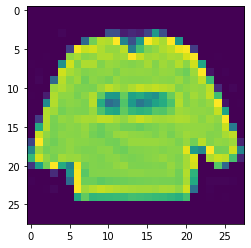

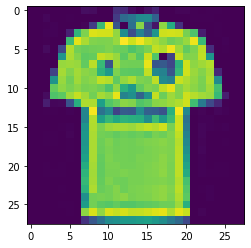

0
2500
5000
[Epoch:001] train loss: 1.27522 train accuracy: 0.5802 | valid loss: 0.80852 valid accuracy: 0.7242
0
2500
5000
[Epoch:002] train loss: 0.84456 train accuracy: 0.7072 | valid loss: 0.65132 valid accuracy: 0.7780
0
2500
5000
[Epoch:003] train loss: 0.75589 train accuracy: 0.7374 | valid loss: 0.61427 valid accuracy: 0.7828
0
2500
5000
[Epoch:004] train loss: 0.70661 train accuracy: 0.7549 | valid loss: 0.58933 valid accuracy: 0.7964
0
2500
5000
[Epoch:005] train loss: 0.67584 train accuracy: 0.7671 | valid loss: 0.57445 valid accuracy: 0.7975
0
2500
5000
[Epoch:006] train loss: 0.65199 train accuracy: 0.7745 | valid loss: 0.52296 valid accuracy: 0.8181
0
2500
5000
[Epoch:007] train loss: 0.63198 train accuracy: 0.7829 | valid loss: 0.52093 valid accuracy: 0.8128
0
2500
5000
[Epoch:008] train loss: 0.61338 train accuracy: 0.7874 | valid loss: 0.54415 valid accuracy: 0.8083
0
2500
5000
[Epoch:009] train loss: 0.59635 train accuracy: 0.7939 | valid loss: 0.49434 valid accuracy:

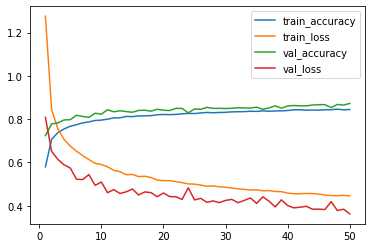

accuracy : 87.27384868421053% precision : 87.33229078329101%, recall : 87.29154945786108% f1 score : 87.05770388503892%


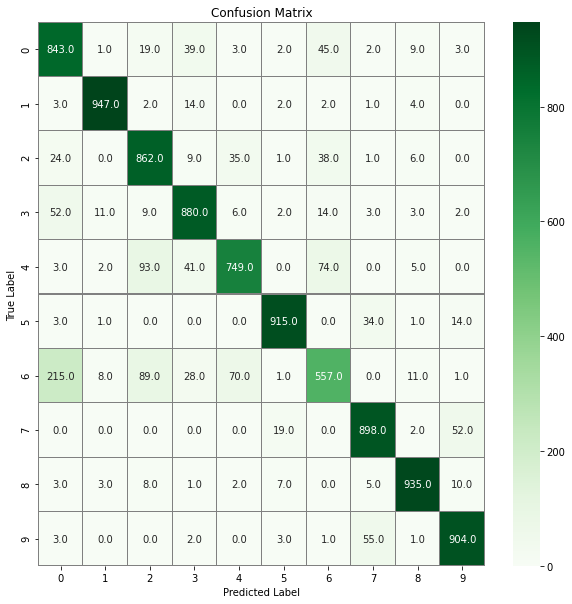

ModuleAttributeError: ignored

In [ ]:
import torch
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
#confusion matrix visualization
import seaborn as sns
#consufion matrix
from sklearn.metrics import confusion_matrix, f1_score, precision_score,recall_score, accuracy_score
#이미지 확인함수
def showimage(data):
    data = data.reshape(28, 28)
    plt.imshow(data)
    plt.show()

#결과 분석함수
def analyze_result(y_true, y_pred, train_accuracy_list, train_loss_list, val_accuracy_list, val_loss_list):
    confusion_mat = confusion_matrix(y_true, y_pred)
    epochs = len(train_accuracy_list)+1
    plt.plot(range(1, epochs), train_accuracy_list, label = "train_accuracy")
    plt.plot(range(1, epochs), train_loss_list, label = "train_loss")
    plt.plot(range(1, epochs), val_accuracy_list, label = "val_accuracy")
    plt.plot(range(1, epochs), val_loss_list, label = "val_loss")
    plt.legend()
    plt.show()
    f, ax = plt.subplots(figsize = (10,10))
    print("accuracy : {}% precision : {}%, recall : {}% f1 score : {}%".
          format(100*accuracy_score(y_true, y_pred), 100* precision_score(y_true, y_pred, average = "macro"),100*recall_score(y_true, y_pred, average = "macro"), 100*f1_score(y_true, y_pred, average= "macro")))
    sns.heatmap(confusion_mat, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


# Dataset Class
class FashionMnist(Dataset):
    def __init__(self, data_path, is_train=True):
        filename = os.path.join(data_path, 'fashion-mnist_train.csv' if is_train else 'fashion-mnist_test.csv')
        assert os.path.exists(filename), 'File not found error'
        self.is_train = is_train
        self.data = pd.read_csv(filename).to_numpy(dtype=np.float32)
        # sort 하면 0 부터 9까지 순서대로 되므로 적절한 훈련이 될 수 없다.
        # self.data = self.data.sort_values(by=['label']).to_numpy(dtype=np.float32)
        self.data_y = self.data[:, 0].astype(np.int)
        self.data_x = self.data[:, 1:]
        #matplotlib를 활용하여 첫번째 이미지 확인
        showimage(self.data_x[0])
        self.data_shape = (28, 28)
        self.transform = transforms.Compose(
            [
                transforms.ToPILImage(),
                #channel 이 1이라 ColorJitter가 안되는것 같다
                #transforms.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(75),
                transforms.ToTensor()
            ]
        )

    def __len__(self):
        return len(self.data_y)

    def __getitem__(self, index):
        ret_x = np.reshape(self.data_x[index], self.data_shape)
        if self.is_train:  # augmentation
            ret_x = self.transform(ret_x)
        else:
            #validation set에서도 마찬가지로 Tensor로 바꿔 주어야한다.
            ret_x = transforms.Compose([transforms.ToTensor()])(ret_x)

        ret_y = self.data_y[index]
        return {"data_x": ret_x, "data_y": ret_y}


# Model Class
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            #레이어의 순서 Conv - BN - RELU - POOL
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

    def forward(self, tensor):
        return self.block(tensor)


class BasicModel(nn.Module):
    def __init__(self, in_channel, num_classes, batch_size):
        super(BasicModel, self).__init__()
        self.batch_size = batch_size
        # 32 -> 64
        k = 64
        self.block = nn.Sequential(
            ConvBlock(in_channel, k),
            ConvBlock(k, k * 2)
            # Pooling으로 인해 28 * 28 -> 14 * 14 -> 7 * 7 에서 손실이 일어나고 너무작아지므로 2개의 레이어를 삭제
            # ConvBlock(k * 2, k * 4),
            # ConvBlock(k * 4, k * 2)
        )
        # 변경된 마지막 레이어의 크기를 적용하여 7*7
        self.linear = nn.Linear(k * 2 * 7 * 7, num_classes)

    def forward(self, tensor):
        out = self.block(tensor)
        #모순적인 shape
        out = out.view(self.batch_size, -1)
        return self.linear(out)


def main():
    #batch size가 너무 작아서 크게 함
    batch_size = 512
    epoch = 50
    # learning rate가 너무 크다
    learning_rate = 1e-03
    in_channel = 1
    num_classes = 10
    #논문에 따르면 beta1 = 0.9 beta2 = 0.999가 가장 무난한 값으로 명시되어 있다. 
    betas = (0.9, 0.999)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_dataset = FashionMnist('./drive/My Drive/DL_study/4_week/fashion_mnist', True)
    valid_dataset = FashionMnist('./drive/My Drive/DL_study/4_week/fashion_mnist', False)
    #마지막 셋은 drop
    train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, drop_last=True, pin_memory=True)

    model = BasicModel(in_channel=in_channel, num_classes=num_classes, batch_size = batch_size).to(device)
    #모델 로드
    if os.path.exists("./drive/My Drive/DL_study/4_week/save_model/correct_model.pth"):
        model.load_state_dict("./drive/My Drive/DL_study/4_week/save_model/correct_model.pth")
        print("model load success!!")

    #클래스가 2개 이상이므로 binary로 하면 안된다.
    criterion = nn.CrossEntropyLoss()  #Cross Entropy Loss
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=betas)
    #accuracy / loss function을 그리기 위한 리스트
    train_accuracy_list= []
    train_loss_list = []
    val_accuracy_list = []
    val_loss_list = []
    for ep in range(epoch):
        # train
        avg_loss = 0
        avg_acc = 0

        count = 0
        model.train()
        for idx, batch in enumerate(train_loader):
            optim.zero_grad()
            #GPU로 넘겨주기
            batch_x = batch['data_x'].to(device)
            batch_y = batch['data_y'].to(device)
            output = model(batch_x)
            loss = criterion(output, batch_y)
            avg_loss += loss.item()

            # cal accuracy
            _, index = torch.max(output, 1)
            avg_acc += (index == batch_y).sum().float() / len(batch_y)
            count += 1

            loss.backward()
            optim.step()
            if idx % 50 ==0:
                print(idx*50)

        avg_loss /= count
        avg_acc /= count
        train_accuracy_list.append(avg_acc)
        train_loss_list.append(avg_loss)
        # valid
        avg_test_loss = 0
        avg_test_acc = 0

        count = 0
        #evaluation 모드
        model.eval()
        with torch.no_grad():
            #마찬가지로 enumerate 붙이기
            for idx, batch in enumerate(valid_loader):
                #그냥 통과해야됨
                #optim.zero_grad()
                #마찬가지로 GPU로 넘겨주기
                batch_x = batch['data_x'].to(device)
                batch_y = batch['data_y'].to(device)
                output = model(batch_x)
                loss = criterion(output, batch_y)
                avg_test_loss += loss.item()

                # cal accuracy
                _, index = torch.max(output, 1)
                avg_test_acc += (index == batch_y).sum().float() / len(batch_y)
                count += 1
            
            avg_test_loss /= count
            avg_test_acc /= count
            val_accuracy_list.append(avg_test_acc)
            val_loss_list.append(avg_test_loss)
        print("[Epoch:%03d] train loss: %.5f train accuracy: %.4f | valid loss: %.5f valid accuracy: %.4f"
              % (ep + 1, avg_loss, avg_acc, avg_test_loss, avg_test_acc))

    print("Training Done.")

    #confusion matrix를 위한 valid set evaluation
    model.eval()
    with torch.no_grad():
        y_true = []
        y_pred = []
        for idx, batch in enumerate(valid_loader):
            batch_x = batch["data_x"].to(device)
            batch_y = batch["data_y"].to(device)
            output = model(batch_x)
            _, index = torch.max(output, 1)
            y_pred += index.cpu().numpy().tolist()
            y_true += batch_y.cpu().numpy().tolist()
    analyze_result(y_true, y_pred, train_accuracy_list, train_loss_list, val_accuracy_list, val_loss_list)
    
    #모델 저장
    torch.save(model, "./save_model/correct_model.pth")
    print("model save success!!")
            

if __name__ == "__main__":
    main()